In [2]:
# Imports
import pandas as pd
from dotenv import load_dotenv
import os
import csv
import spacy 
import time
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Data processing

In [ ]:
load_dotenv()
filepath = os.getenv('FILEPATH')

**Reading the original dataset into Pandas dataframe and splitting the data into train (80), validation (10) and test (10) sets**

In [ ]:

"""
The corpus is formatted as a CSV and contains the following fields:

    id
    domain
    type
    url
    content
    scraped_at
    inserted_at
    updated_at
    title
    authors
    keywords
    meta_keywords
    meta_description
    tags
    summary
    source (opensources, nytimes, or webhose)
"""
csv.field_size_limit(100000000)


selected_columns = ["domain", "title", "authors", "type", "content", "url"]
sample_chunks = []
for chunk in pd.read_csv(filepath, usecols=selected_columns, chunksize=100000, on_bad_lines='warn', engine='python'):
    sample = chunk.sample(frac=0.1, random_state=42)
    sample_chunks.append(sample)
    df = pd.concat(sample_chunks, ignore_index=True)

train_dataframe, temp_dataframe = train_test_split(df, test_size=0.2, random_state=42) # 80% for training, temp variable for validation and testing
validation_dataframe, test_dataframe = train_test_split(temp_dataframe, test_size=0.5, random_state=42) # splitting the temp data into 10% for validation and 10% for testing

train_dataframe.to_csv("data/train_data.csv", chunksize=100000)
validation_dataframe.to_csv("data/validation_data.csv", chunksize=100000)
test_dataframe.to_csv("data/test_data.csv", chunksize=100000)

**Processing the data using SpaCy nlp library**

In [ ]:
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"]) # https://www.geeksforgeeks.org/tokenization-using-spacy-library/
selected_columns = ["domain", "title", "authors", "type", "content", "url"]

# counter info https://www.geeksforgeeks.org/python-counter-objects-elements/
lemmatized_vocab_counter = Counter() # number of lemmatized words without stopwords 
stopword_counter = Counter() 
filtered_vocab_counter = Counter() # number of words without stopwords
original_vocab = set()
csv.field_size_limit(100000000)

# I used chatgpt here for understanding how to use spacy and processing the texts in batches to make the processing more efficient
# spacy docs: https://spacy.io/usage/processing-pipelines 
def preprocess(texts):
    for doc in nlp.pipe(texts, batch_size=500, n_process=4): # batch size is the number of texts to process at once

        for token in doc: # token is a single word/punctuation in a list of tokens
            if token.is_alpha: # check if token is a word
                original_vocab.add(token.text.lower())
                word = token.text.lower()
                if (token.is_stop): # if the token is a stopword, add to counter
                    stopword_counter[word] += 1
                else: # otherwise update the filtered vocab counter and lemmatized vocab counter
                    filtered_vocab_counter[word] += 1
                    lemmatized_vocab_counter[token.lemma_.lower()] += 1 
        
        yield " ".join(token.lemma_.lower() for token in doc if token.is_alpha and not token.is_stop)

input_files = ["data/train_data.csv", "data/validation_data.csv", "data/test_data.csv"]
output_files = ["data/processed_train.csv", "data/processed_validation.csv", "data/processed_test.csv"]

for input_file, output_file in zip(input_files, output_files):
    print(f"Processing {input_file}")
    first_chunk = True

    # writing the processed text data into another file
    with open(output_file, "w", encoding="utf-8") as f_out: 
        for chunk in pd.read_csv(input_file, encoding="utf-8", usecols=selected_columns, on_bad_lines='warn', chunksize=1024, engine='python'):
            start = time.time() # timing the chunk processing for debugging

            # adding label column which tells whether the article is reliable (=1) or not (=0)
            chunk["label"] = chunk["type"].apply(lambda x: 1 if str(x).strip().lower() == "reliable" else 0)
            # collecting yields into a list
            texts = chunk["content"].fillna("").astype(str).tolist() # content column to a list
            processed = list(preprocess(texts)) # processing the list
            chunk["processed_text"] = processed # assigning back to chunk

            print(f"Chunk processed in {time.time() - start:.2f}s")
            # appending the chunk to the output file
            chunk[["processed_text", "label", "type", "domain", "title", "url", "authors"]].to_csv(f_out, mode="a", header=first_chunk, index=False) 
            first_chunk = False # for the header 


print("Preprocessing done.")

In [7]:
# Reading the processed csv files into Pandas Dataframes
df_train = pd.read_csv("data/processed/processed_train.csv")  
df_valid = pd.read_csv("data/processed/processed_validation.csv")
df_test = pd.read_csv("data/processed/processed_test.csv")  

### Computing reduction rates

In [13]:

stats_path = "data/preprocessing_stats.txt"

if os.path.exists(stats_path): # checking if a statistics file already exists, so we don't have to do the analysis again
    print("Preprocessing stats already exist, reading from file\n")
    with open(stats_path, "r", encoding="utf-8") as f:
        print(f.read())
else: 
    original_vocab_size = len(original_vocab) 
    filtered_vocab_size = len(filtered_vocab_counter)
    lemmatized_vocab_size = len(lemmatized_vocab_counter)

    # reduction rate after stopword removal
    stopword_reduction_rate = ((original_vocab_size - filtered_vocab_size) / original_vocab_size) * 100

    # calculating lemmatized reduction rate
    lemmatized_reduction_rate = ((filtered_vocab_size - lemmatized_vocab_size) / filtered_vocab_size) * 100

    print(f"Original vocabulary size: {original_vocab_size}")
    print(f"Vocabulary size after removing stopwords: {filtered_vocab_size}")
    print(f"Vocabulary size after lemmatization: {lemmatized_vocab_size}")
    print(f"Stopword reduction rate: {stopword_reduction_rate:.2f}%")
    print(f"lemmatized reduction rate: {lemmatized_reduction_rate:.2f}%")

    with open("data/preprocessing_stats.txt", "w", encoding="utf-8") as f:
        f.write(f"Original vocabulary size: {original_vocab_size}\n")
        f.write(f"Vocabulary size after removing stopwords: {filtered_vocab_size}\n")
        f.write(f"Vocabulary size after lemmatization: {lemmatized_vocab_size}\n")
        f.write(f"Stopword reduction rate: {stopword_reduction_rate:.2f}%\n")
        f.write(f"Lemmatized reduction rate: {lemmatized_reduction_rate:.2f}%\n")

    



Preprocessing stats already exist, reading from file

Original vocabulary size: 1107067
Vocabulary size after removing stopwords: 1106762
Vocabulary size after lemmatization: 1085243
Stopword reduction rate: 0.03%
Lemmatized reduction rate: 1.94%



In [70]:
print(df_train.head()) 

                                      processed_text  label       type  \
0  times cover widely regard major american fashi...      1   reliable   
1  dear reader excited announce voice russia chan...      0       bias   
2     late deliver daily friend think read newspaper      0  political   
3  receive natural health newsletter free subscri...      0    junksci   
4  break tradition budget year yes go deliver fal...      0     satire   

            domain                                              title  \
0      nytimes.com  Gösta Peterson, Barrier-Breaking Fashion Photo...   
1  sputniknews.com  austerity, 2013 : The Voice of Russia: News, B...   
2      pjmedia.com  'Hell or High Water' Is A Pro-Second Amendment...   
3  naturalnews.com  antidepressants articles and information on th...   
4   fridaymash.com                     The Remotest Idea - FridayMash   

                                                 url      authors  text_length  
0  https://www.nytimes.com/2017/08/

### Exploring training data after preprocessing

**Precentage distribution of labels in the dataset**

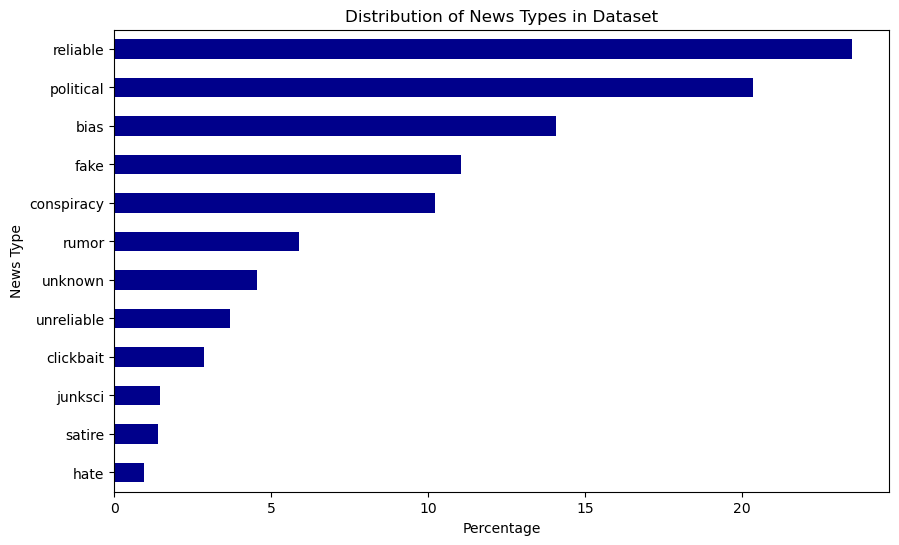

In [15]:
type_distribution = df_train["type"].value_counts(normalize=True) * 100 # counting the distribution
type_distribution.sort_values().plot(kind="barh", figsize=(10, 6), color="darkblue") # plotting a horizontal bar

plt.xlabel("Percentage")
plt.ylabel("News Type")
plt.title("Distribution of News Types in Dataset")
plt.show()

**Visualizing the distribution of words in reliable vs non-reliable news**

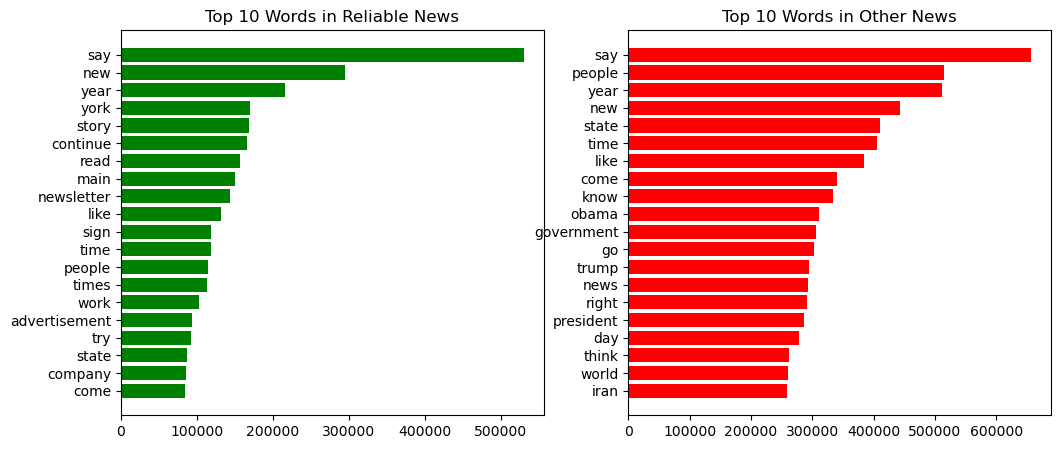

In [16]:
reliable_texts = df_train[df_train["label"] == 1]["processed_text"].dropna().astype(str)
other_texts = df_train[df_train["label"] != 1]["processed_text"].dropna().astype(str)

reliable_counter = Counter()
for text in reliable_texts:
    reliable_counter.update(text.split())

other_counter = Counter()
for text in other_texts:
    other_counter.update(text.split())

# counting the top 10 words in reliable and other news
reliable_top10 = reliable_counter.most_common(20)
other_top10 = other_counter.most_common(20)

# unzipping the word and count pairs
words_r, counts_r = zip(*reliable_top10) # https://www.w3schools.com/python/ref_func_zip.asp
words_o, counts_o = zip(*other_top10)

plt.figure(figsize=(12, 5))

# Plot reliable
plt.subplot(1, 2, 1)
plt.barh(words_r[::-1], counts_r[::-1], color="green")
plt.title("Top 10 Words in Reliable News")

# Plot other
plt.subplot(1, 2, 2)
plt.barh(words_o[::-1], counts_o[::-1], color="red")
plt.title("Top 10 Words in Other News")

plt.show()


**Average and median text lengths by news label (fake or reliable)**

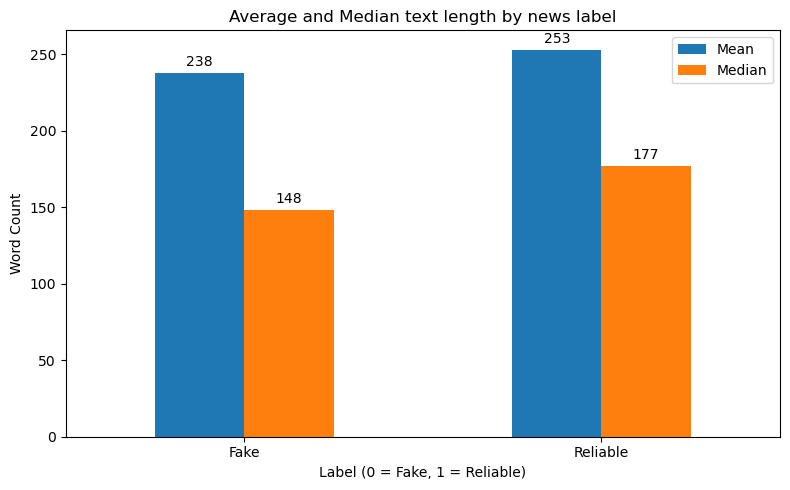

In [22]:
df_train["text_length"] = df_train["processed_text"].fillna("").astype(str).apply(lambda x: len(x.split()))
avg_md_stats = df_train.groupby("label")["text_length"].agg(["mean", "median"])

ax = avg_md_stats.plot(kind="bar", figsize=(8, 5))
plt.title("Average and Median text length by news label")
plt.xlabel("Label (0 = Fake, 1 = Reliable)")
plt.ylabel("Word Count")
plt.xticks(ticks=[0, 1], labels=["Fake", "Reliable"], rotation=0)
plt.legend(["Mean", "Median"])
plt.tight_layout()
for container in ax.containers:
    ax.bar_label(container, fmt="%.0f", padding=3)
plt.show()


**Pie chart of distribution between reliable vs fake news**

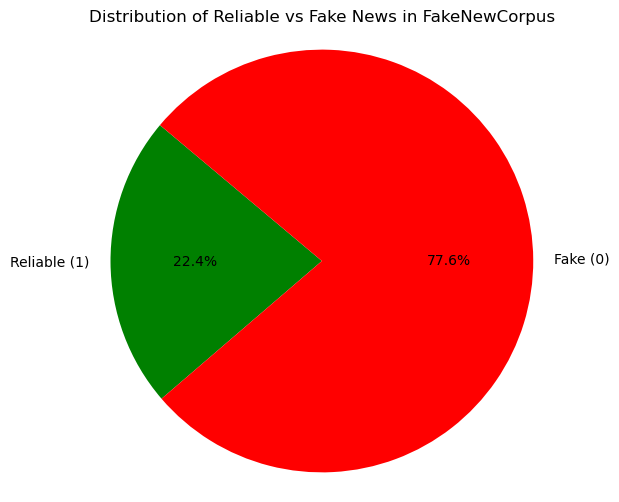

In [8]:
# counting reliable and fake news
label_counts = df_train["label"].value_counts()

# labels and sizes
labels = ["Reliable (1)", "Fake (0)"]
sizes = [label_counts.get(1, 0), label_counts.get(0, 0)] 
colors = ["green", "red"]

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct="%1.1f%%", startangle=140)
plt.title("Distribution of Reliable vs Fake News in FakeNewCorpus")
plt.axis("equal")
plt.show()


**Confusion matrix function**

In [39]:
# reference: https://www.w3schools.com/python/python_ml_confusion_matrix.asp
def confusion_matrix_fig(y_test, y_pred_test, title):
    cm = confusion_matrix(y_test, y_pred_test)

    # Plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake (0)", "Real (1)"])
    disp.plot(cmap="Blues")  # You can change the colormap if you like
    plt.title(f"Confusion Matrix: {title}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Simple model development using Naive Bayes

In [36]:
# imports for simple model
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack

**Initial model using only the content and label for building the model**

In [ ]:
# extracting input features (x) and labels (y) from all datasets for the model
# processed_text is the feature used for modeling and label tells whether the article is fake or not
x_train_sm = df_train["processed_text"].fillna("") # replacing missing text with empty strings
y_train_sm = df_train["label"]

x_valid_sm = df_valid["processed_text"].fillna("")
y_valid_sm = df_valid["label"]

x_test_sm = df_test["processed_text"].fillna("")
y_test_sm = df_test["label"]


In [ ]:
# vectorizing text data using TF-IDF with bigrams (= 2-word combinations for 
# the model to learn more context relationships between words)
vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(2, 2))

# fitting the vectorizer on training data and transforming it into TF-IDF vectors
x_train_vec = vectorizer.fit_transform(x_train_sm)

# transforming validation and test data using the fitted vectorizer
x_val_vec = vectorizer.transform(x_valid_sm)
x_test_vec = vectorizer.transform(x_test_sm)

In [ ]:
# training the naive bayes model which is suitable for 
# classification tasks with discrete features (such as TF-IDF)
simple_model = MultinomialNB()
simple_model.fit(x_train_vec, y_train_sm)

MultinomialNB()

In [ ]:
# evaluating the model with validation data

y_pred_val = simple_model.predict(x_val_vec) # predict labels
print("Validation data accuracy:", accuracy_score(y_valid_sm, y_pred_val))
print(classification_report(y_valid_sm, y_pred_val))

Validation data accuracy: 0.8658592348547912
              precision    recall  f1-score   support

           0       0.85      1.00      0.92     66089
           1       0.99      0.41      0.58     19202

    accuracy                           0.87     85291
   macro avg       0.92      0.70      0.75     85291
weighted avg       0.88      0.87      0.84     85291



Test data accuracy: 0.8672896319658581
              precision    recall  f1-score   support

           0       0.85      1.00      0.92     66171
           1       1.00      0.41      0.58     19120

    accuracy                           0.87     85291
   macro avg       0.92      0.70      0.75     85291
weighted avg       0.89      0.87      0.84     85291



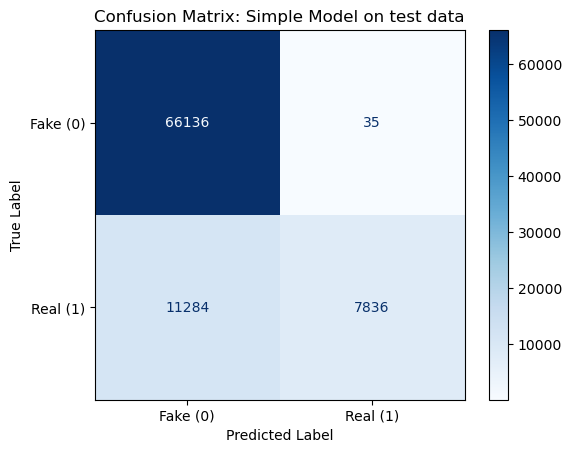

In [ ]:
# evaluating with test data

y_pred_test = simple_model.predict(x_test_vec) # predict labels
print("Test data accuracy:", accuracy_score(y_test_sm, y_pred_test))
print(classification_report(y_test_sm, y_pred_test))

confusion_matrix_fig(y_test_sm, y_pred_test, "Simple Model on test data")

### Using more metadata for the model

**Using domain and title for additional data to predict fake news**

In [ ]:
# one-hot-encoding domain-feature, which converts the data into
# binary feature vectors

domain_ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=True) 
domain_encoded = domain_ohe.fit_transform(df_train[["domain"]])

# creating TF-IDF vectors from title and removing stopwords from the titles
# the vectors are limited to include 500 most important terms
title_vec = TfidfVectorizer(max_features=500, stop_words='english')
title_encoded = title_vec.fit_transform(df_train["title"].fillna(""))


In [ ]:
# combining features into one matrix for training
# - x_train_vec: TF-IDF vectors from the processed article text
# - domain_encoded: One-hot encoded domain-feature
# - title_encoded: TF-IDF vectors from the article titles

x_combined_train = hstack([x_train_vec, domain_encoded, title_encoded])

In [ ]:
# training new naive bayes model with new metadata featuers

meta_model = MultinomialNB()
meta_model.fit(x_combined_train, y_train_sm)

MultinomialNB()

**Evaluating with validation data**

In [ ]:
# transforming the validation set using the already-fitted encoders/vectorizers
domain_encoded_valid = domain_ohe.transform(df_valid[["domain"]])
title_encoded_valid = title_vec.transform(df_valid["title"].fillna(""))

In [18]:
x_combined_val = hstack([x_val_vec, domain_encoded_valid, title_encoded_valid])

# evaluating
y_pred_val_meta = meta_model.predict(x_combined_val)

print("Validation data accuracy:", accuracy_score(y_valid_sm, y_pred_val_meta))
print(classification_report(y_valid_sm, y_pred_val_meta))

Validation data accuracy: 0.9887913144411485
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     66089
           1       1.00      0.95      0.97     19202

    accuracy                           0.99     85291
   macro avg       0.99      0.98      0.98     85291
weighted avg       0.99      0.99      0.99     85291



**Finally with test data**

In [ ]:
# transforming the validation set using the already-fitted encoders/vectorizers
domain_encoded_test = domain_ohe.transform(df_test[["domain"]])
title_encoded_test = title_vec.transform(df_test["title"].fillna(""))

Test data accuracy: 0.9881699124174884
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     66171
           1       1.00      0.95      0.97     19120

    accuracy                           0.99     85291
   macro avg       0.99      0.97      0.98     85291
weighted avg       0.99      0.99      0.99     85291



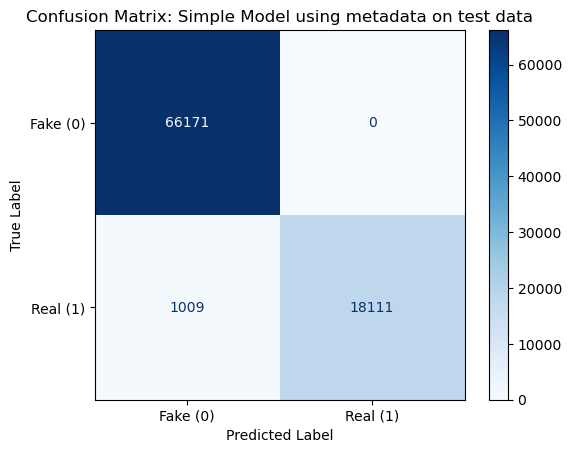

In [21]:
x_combined_test = hstack([x_test_vec, domain_encoded_test, title_encoded_test])

# evaluating
y_pred_meta = meta_model.predict(x_combined_test)

print("Test data accuracy:", accuracy_score(y_test_sm, y_pred_meta))
print(classification_report(y_test_sm, y_pred_meta))

confusion_matrix_fig(y_test_sm, y_pred_meta, "Simple Model using metadata on test data")

**saving models**

In [ ]:
import joblib

#joblib.dump(model, "models/simple_model.joblib")
joblib.dump(meta_model, "models/simple_model_meta.joblib")

joblib.dump(vectorizer, "models/tfidf_bigrams_vectorizer.joblib")

# Avanced model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model
from keras.callbacks import EarlyStopping
import pickle

In [ ]:
# constants for text preprocessing and model architecture
MAX_WORDS=10000 # max number of words to keep in the tokenizer vocab
MAX_LEN=100 # max length of input sequences in tokens
LSTM_UNITS=128 # number of LSTM units in the model (before finetuning: 64)
NUM_CLASSES=1 # binary classification -> one output neuron with sigmoid activation 

# loading the pre-trained tokenizer and model if those exist 
with open('models/tokenizer.pkl', 'rb') as handle:
    tokenizer = pickle.load(handle)

model = load_model("models/advanced_model.keras")


### Training the LSTM model

In [ ]:
# reference for building the model: https://spotintelligence.com/2023/01/11/lstm-in-nlp-tasks/

# extracting input features (x) and labels (y) 
x_train = df_train["processed_text"].fillna("").astype(str).tolist() # text is non-null and in string format
y_train = df_train["label"].values

# tokenizer setup which converts text into sequences of integers
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>") # using max vocab size and set token for OOV (out of vocab) words

# fitting the tokenizer on the training texts
tokenizer.fit_on_texts(x_train)
# text to sequences of integers
sequences = tokenizer.texts_to_sequences(x_train)

# padding sequences make all sequences the same length for the LSTM model
xTrain = pad_sequences(sequences, maxlen=MAX_LEN, padding='post')

# saving the tokenizer for  futuer use
with open("models/tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

In [ ]:
# Building the LSTM model
model = Sequential()

# embedding layer which converts each word index from tokenizer into a dense vector of 100 dimensions
# this part helps model capture similarities between words and learn the meaning of words
model.add(Embedding(MAX_WORDS, 100)) # before finetuning: 32

# adding the LSTM layer to capture sequential dependencies
model.add(LSTM(LSTM_UNITS))

# dropout layer to prevent overfitting
model.add(Dropout(0.5)) # added for finetuning

# output layer: single neuron with sigmoid activation for binary classification
model.add(Dense(NUM_CLASSES, activation='sigmoid'))

In [32]:
# Compiling model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# training the model

# early stopping is used to monitor validation loss during training
# training stops if the validation loss does not improve in 3 consecutive epochs 
# helps prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# validation_split splits 20% off from training data to validation, needed for the callback
history = model.fit(xTrain, y_train, batch_size=32, epochs=15, validation_split=0.2, callbacks=[early_stop])

Epoch 1/15
17059/17059 ━━━━━━━━━━━━━━━━━━━━ 843s 49ms/step - accuracy: 0.8959 - loss: 0.2580 - val_accuracy: 0.9393 - val_loss: 0.1503
Epoch 2/15
17059/17059 ━━━━━━━━━━━━━━━━━━━━ 884s 52ms/step - accuracy: 0.9511 - loss: 0.1281 - val_accuracy: 0.9465 - val_loss: 0.1373
Epoch 3/15
17059/17059 ━━━━━━━━━━━━━━━━━━━━ 826s 48ms/step - accuracy: 0.9605 - loss: 0.1025 - val_accuracy: 0.9469 - val_loss: 0.1386
Epoch 4/15
17059/17059 ━━━━━━━━━━━━━━━━━━━━ 824s 48ms/step - accuracy: 0.9677 - loss: 0.0840 - val_accuracy: 0.9463 - val_loss: 0.1480
Epoch 5/15
17059/17059 ━━━━━━━━━━━━━━━━━━━━ 838s 49ms/step - accuracy: 0.9744 - loss: 0.0679 - val_accuracy: 0.9450 - val_loss: 0.1654


In [34]:
model.save("models/advanced_model_finetuned.keras")  # saving model for later use

In [43]:
model = load_model("models/advanced_model.keras")
# model = load_model("models/advanced_model_finetuned.keras")

### Validating

In [44]:
x_valid = df_valid["processed_text"].fillna("").astype(str).tolist()
y_valid = df_valid["label"].values

sequences = tokenizer.texts_to_sequences(x_valid)

# replacing empty arrays to [1] since pad_sequences thorws error on empty sequence arrays
sequences = [seq if seq else [1] for seq in sequences]

# padding sequences make all sequences the same length
xValid = pad_sequences(sequences, maxlen=MAX_LEN, padding='post')

# predictions
y_pred_probs = model.predict(xValid)
y_pred = (y_pred_probs >= 0.5).astype(int).flatten() 

# evaluation
print(classification_report(y_valid, y_pred))



2666/2666 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step
              precision    recall  f1-score   support

           0       0.96      0.97      0.96     66089
           1       0.89      0.85      0.87     19202

    accuracy                           0.94     85291
   macro avg       0.92      0.91      0.91     85291
weighted avg       0.94      0.94      0.94     85291



### Evaluating the model

2666/2666 ━━━━━━━━━━━━━━━━━━━━ 23s 8ms/step
              precision    recall  f1-score   support

           0       0.96      0.97      0.96     66171
           1       0.89      0.85      0.87     19120

    accuracy                           0.94     85291
   macro avg       0.92      0.91      0.92     85291
weighted avg       0.94      0.94      0.94     85291

2666/2666 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - accuracy: 0.9414 - loss: 0.2352
Test Loss: 0.2308
Test Accuracy: 0.9417


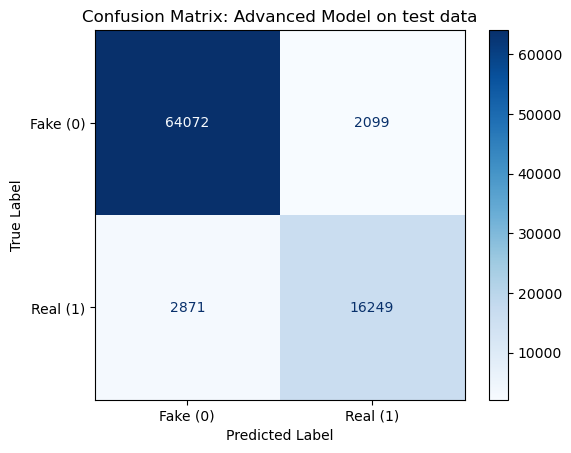

In [45]:
x_test = df_test["processed_text"].fillna("").astype(str).tolist()
y_test = df_test["label"].values

sequences = tokenizer.texts_to_sequences(x_test)

# replacing empty arrays to [1] since pad_sequences thorws error on empty sequence arrays
sequences = [seq if seq else [1] for seq in sequences]

# padding sequences make all sequences the same length
xTest = pad_sequences(sequences, maxlen=MAX_LEN, padding='post')

# predictions
y_pred_probs = model.predict(xTest)
y_pred = (y_pred_probs >= 0.5).astype(int).flatten() 

# evaluation
print(classification_report(y_test, y_pred))

loss, accuracy = model.evaluate(xTest, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

confusion_matrix_fig(y_test, y_pred, "Advanced Model on test data")

# Testing models with LIAR dataset

**Preprocessing the LIAR data**

In [ ]:
liar_test_filepath = "data/liar/test.tsv"
liar_valid_filepath = "data/liar/valid.tsv"
liar_train_filepath = "data/liar/train.tsv"
 
# convert liar data to csv
# liar headers
liar_headers= ["id", "label", "statement", "subject", "speaker", "job_title", "state_info", "party_affiliation",
                "barely_true_counts", "false_counts", "half_true_counts", "mostly_true_counts", "pants_onfire_counts", "context"]
# convert liar data to csv
liar_test_df = pd.read_csv(liar_test_filepath, sep="\t", header=None, names=liar_headers)
liar_valid_df = pd.read_csv(liar_valid_filepath, sep="\t", header=None, names=liar_headers)
liar_train_df = pd.read_csv(liar_train_filepath, sep="\t", header=None, names=liar_headers)
 
liar_test_df.to_csv("data/liar/test.csv", index=False)
liar_valid_df.to_csv("data/liar/valid.csv", index=False)
liar_train_df.to_csv("data/liar/train.csv", index=False)
 
# labels in liar = true, false, half-true, pants-fire, barely-true, mostly-true
# only true and mostly-true are true others are false
# converting labels to binary 1=true, 0=false
liar_selected_columns = ["label", "subject", "statement"]
 
input_files = ["data/liar/train.csv", "data/liar/test.csv", "data/liar/valid.csv"]
output_files = ["data/liar/train_processed.csv", "data/liar/test_processed.csv", "data/liar/valid_processed.csv"]

nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"]) # https://www.geeksforgeeks.org/tokenization-using-spacy-library/
def preprocess_liar(texts):
    for doc in nlp.pipe(texts, batch_size=500, n_process=4): # batch size is the number of texts to process at once
        yield " ".join(token.lemma_.lower() for token in doc if token.is_alpha and not token.is_stop)

for input_file, output_file in zip(input_files, output_files):
    print(f"Processing {input_file}")
    first_chunk = True

    # writing the processed text data into another file
    with open(output_file, "w", encoding="utf-8") as f_out: 
        for chunk in pd.read_csv(input_file, encoding="utf-8", usecols=liar_selected_columns, on_bad_lines='warn', chunksize=1024, engine='python'):
            start = time.time() # timing the chunk processing for debugging

            # adding label column which tells whether the article is reliable (=1) or not (=0)
            chunk["bin_label"] = chunk["label"].apply(lambda x: 1 if str(x).strip().lower() in ["true", "mostly-true"] else 0)
            # collecting yields into a list
            texts = chunk["statement"].fillna("").astype(str).tolist() # content column to a list
            processed = list(preprocess_liar(texts)) # processing the list
            chunk["processed_text"] = processed # assigning back to chunk
            chunk["domain"] = chunk["subject"].fillna("unknown")
            chunk["title"] = chunk["statement"]

            print(f"Chunk processed in {time.time() - start:.2f}s")
            # appending the chunk to the output file
            chunk[["processed_text", "bin_label", "subject", "label", "title", "domain"]].to_csv(f_out, mode="a", header=first_chunk, index=False) 
            first_chunk = False # for the header 


print("Preprocessing done.")

Processing data/liar/train.csv
Chunk processed in 10.36s
Chunk processed in 10.00s
Chunk processed in 9.40s
Chunk processed in 9.43s
Chunk processed in 9.45s
Chunk processed in 9.50s
Chunk processed in 9.37s
Chunk processed in 9.50s
Chunk processed in 9.36s
Chunk processed in 9.43s
Processing data/liar/test.csv
Chunk processed in 9.49s
Chunk processed in 8.81s
Processing data/liar/valid.csv
Chunk processed in 9.51s
Chunk processed in 8.76s
Preprocessing done.


In [73]:
df_valid_liar = pd.read_csv("data/liar/valid_processed.csv")  
df_test_liar = pd.read_csv("data/liar/test_processed.csv") 
df_train_liar = pd.read_csv("data/liar/train_processed.csv") 

# combining the train, validation and test datasets from LIAR 
# because no need to test those individually on the models
df_liar_all = pd.concat([df_train_liar, df_valid_liar, df_test_liar], ignore_index=True)

**LIAR data explorations**

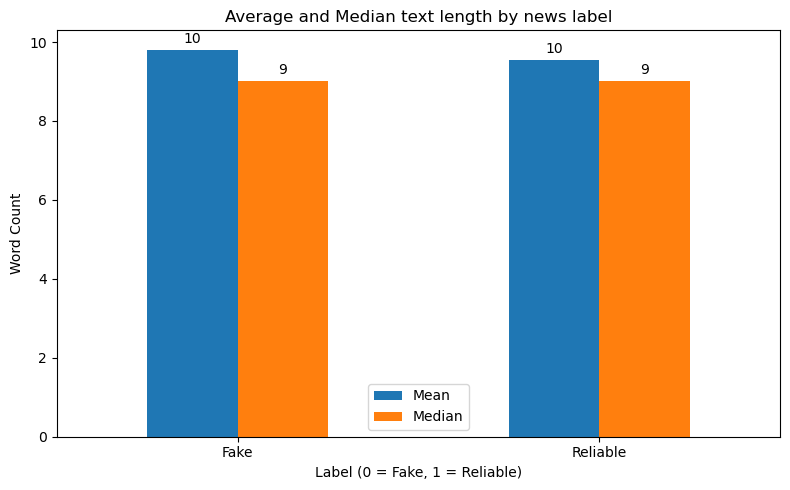

In [74]:
df_liar_all["text_length"] = df_liar_all["processed_text"].fillna("").astype(str).apply(lambda x: len(x.split()))
avg_md_stats = df_liar_all.groupby("bin_label")["text_length"].agg(["mean", "median"])

ax = avg_md_stats.plot(kind="bar", figsize=(8, 5))
plt.title("Average and Median text length by news label")
plt.xlabel("Label (0 = Fake, 1 = Reliable)")
plt.ylabel("Word Count")
plt.xticks(ticks=[0, 1], labels=["Fake", "Reliable"], rotation=0)
plt.legend(["Mean", "Median"])
plt.tight_layout()
for container in ax.containers:
    ax.bar_label(container, fmt="%.0f", padding=3)
plt.show()


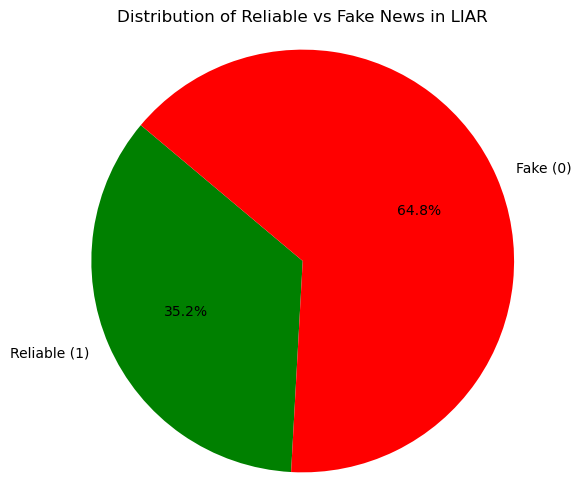

In [75]:
# counting reliable and fake news
label_counts = df_liar_all["bin_label"].value_counts()

# labels and sizes
labels = ["Reliable (1)", "Fake (0)"]
sizes = [label_counts.get(1, 0), label_counts.get(0, 0)] 
colors = ["green", "red"]

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct="%1.1f%%", startangle=140)
plt.title("Distribution of Reliable vs Fake News in LIAR")
plt.axis("equal")
plt.show()


### Simple model with LIAR

**Without metadata**

In [76]:
# prepare text and labels
x_liar_all = df_liar_all["processed_text"].fillna("")
y_liar_all = df_liar_all["bin_label"]

x_liar_vec = vectorizer.transform(x_liar_all)

**Evaluating with LIAR**

In [86]:
y_pred_liar_simple = simple_model.predict(x_liar_vec)
print("Accuracy on LIAR (Simple Model):", accuracy_score(y_liar_all, y_pred_liar_simple))
print(classification_report(y_liar_all, y_pred_liar_simple, zero_division=0))

Accuracy on LIAR (Simple Model): 0.6477210538659995
              precision    recall  f1-score   support

           0       0.65      1.00      0.79      8284
           1       0.67      0.00      0.00      4507

    accuracy                           0.65     12791
   macro avg       0.66      0.50      0.39     12791
weighted avg       0.65      0.65      0.51     12791



**Simple model with metadata**

In [84]:
domain_encoded_liar = domain_ohe.transform(df_liar_all[["domain"]])
title_encoded_liar = title_vec.transform(df_liar_all["title"].fillna(""))

x_combined_liar = hstack([x_liar_vec, domain_encoded_liar, title_encoded_liar])

# evaluating
y_pred_liar_meta = meta_model.predict(x_combined_liar)

print("Accuracy on LIAR (Simple Model with meta-features):", accuracy_score(y_liar_all, y_pred_liar_meta))
print(classification_report(y_liar_all, y_pred_liar_meta, zero_division=0))

Accuracy on LIAR (Simple Model with meta-features): 0.6474865139551247
              precision    recall  f1-score   support

           0       0.65      1.00      0.79      8284
           1       0.25      0.00      0.00      4507

    accuracy                           0.65     12791
   macro avg       0.45      0.50      0.39     12791
weighted avg       0.51      0.65      0.51     12791



### Advanced model with LIAR

**using all data from liar**

In [85]:
x_liar_lstm = df_liar_all["processed_text"].fillna("").astype(str).tolist()
y_liar_lstm = df_liar_all["bin_label"].values

sequences = tokenizer.texts_to_sequences(x_liar_lstm)

# padding sequences make all sequences the same length
xLiar = pad_sequences(sequences, maxlen=MAX_LEN, padding='post')

# predictions
y_pred_probs_liar = model.predict(xLiar)
y_pred_liar = (y_pred_probs_liar >= 0.5).astype(int).flatten() 

# evaluation
print("Advanced Model evaluation on LIAR dataset:")
print(classification_report(y_liar_lstm, y_pred_liar, zero_division=0))

loss, accuracy = model.evaluate(xLiar, y_liar_lstm)
print(f"LIAR Loss: {loss:.4f}")
print(f"LIAR Accuracy: {accuracy:.4f}")


400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
Advanced Model evaluation on LIAR dataset:
              precision    recall  f1-score   support

           0       0.65      0.96      0.78      8284
           1       0.43      0.06      0.10      4507

    accuracy                           0.64     12791
   macro avg       0.54      0.51      0.44     12791
weighted avg       0.57      0.64      0.54     12791

400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6356 - loss: 2.4622
LIAR Loss: 2.4175
LIAR Accuracy: 0.6404


**Confusion matrices**

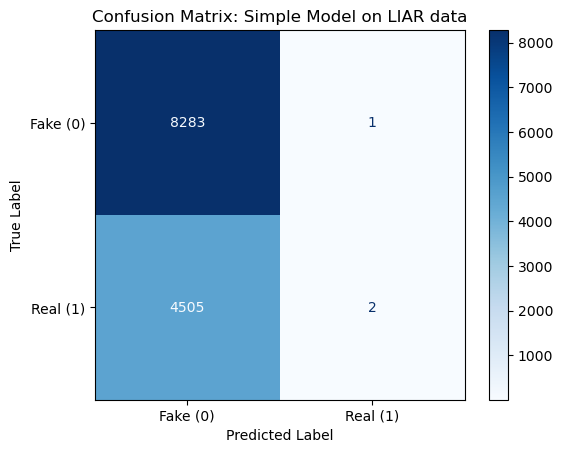

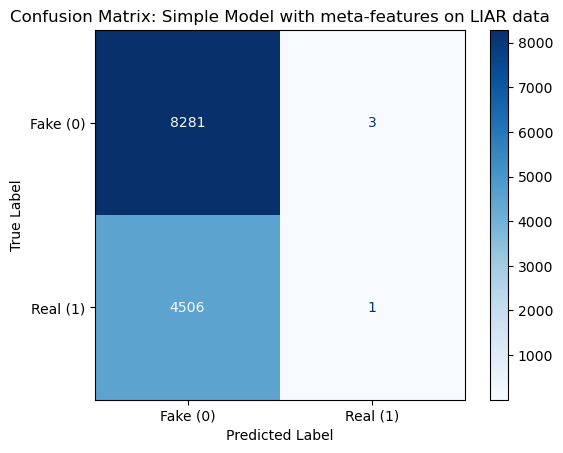

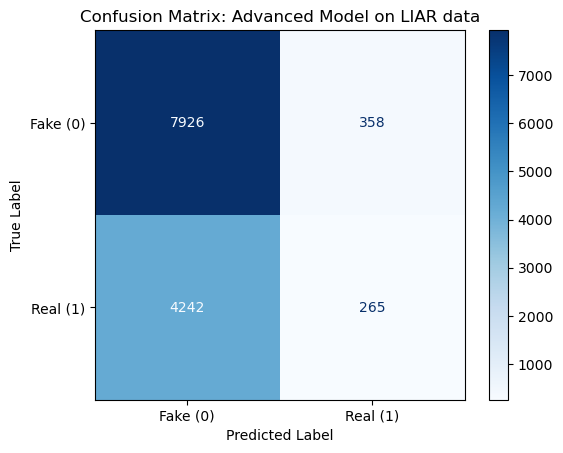

In [88]:
confusion_matrix_fig(y_liar_all, y_pred_liar_simple, "Simple Model on LIAR data")
confusion_matrix_fig(y_liar_all, y_pred_liar_meta, "Simple Model with meta-features on LIAR data")
confusion_matrix_fig(y_liar_lstm, y_pred_liar, "Advanced Model on LIAR data")

# Plots for report conclusion

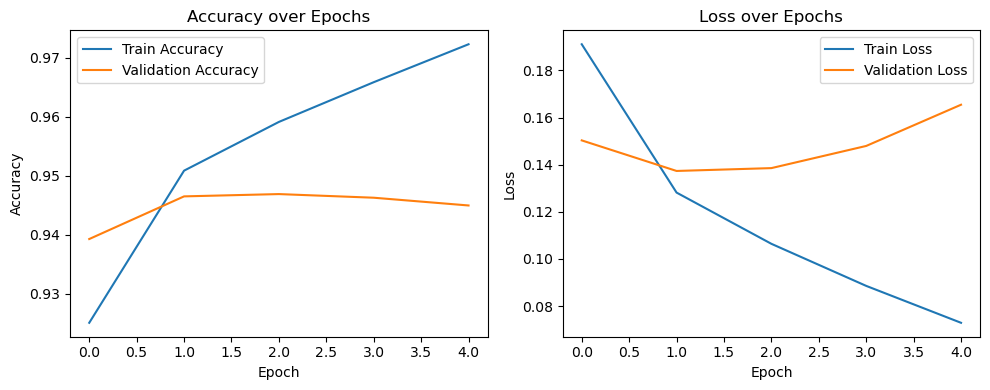

In [ ]:
# plot was generated with ChatGPT4o
def plot_training_history(history):
    plt.figure(figsize=(10, 4))

    # accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)